# Homework 3 - Cleaning and Prepping Data

For this homework, I chose to obtain data by interacting with the API for the Internet Game Database (IGDB.com). The data available on IGDB is a compilation of many different resources, including video game rating agencies like ESRB and PEGI, as well as the promotional material released by publishers pertaining to their games. Because the data available on each game in IGDB is incredibly varied, the sources from which the information is obtained is also necessarily varied. For example, the database includes information about the time it takes to complete games, when playing at a normal pace, or as a record-breaking speedrunner. 

To interact with the IGDB API, I used a number of resources that they provided:

* [IGDB API Documentation](https://igdb.github.io/api/)
* [IGDB Main Website](https://api.igdb.com)
* [IGDB Python API Wrapper Repository](https://github.com/igdb/igdb_api_python)

This data is meaningful to me in a very direct way because my primary major is in Game Design, so the opportunity to incorporate that into my assignment was quite nice, even though it did mean wrestling with a lot of material I wasn't familiar with, namely using an API that turned out to be very challenging to navigate, when I already had very limited experience interacting with APIs to begin with.

For the assignment, I will be looking at a quasi-randomly selected group of games for a particular console. Specifically, I will look at the frequency of the different ESRB ratings among my data sample, and will also try to determine whether there is any relation between ESRB rating and the user ratings that the game receives. Finally, I will look at variation of user ratings for each ESRB rating, as well as variation between ESRB ratings.

## Extra Credit

For this assignment, I will be **tackling pagination** and **incorporating visualizations using** `matplotlib`. These were the obvious choices, because any requests to the IGDB API are automatically paginated, and data visualization is just useful for answering my questions. The location at which I do these things will be documented in the `README.md`.

## Documenting and Selecting Data Set

In [55]:
# To do this import, I first had to install the API wrapper by running:
# `pip install igdb_api_python`
from igdb_api_python.igdb import igdb
import requests

# igdb represents a requests object, as created by the IGDB API wrapper
api_key = "750c9d13c29e3ee77695e1cfebae2c62"
igdb = igdb(api_key)

# this is my attempt to find the id # for PS4 games just by cycling through
# a bunch of platforms entries
platforms = igdb.platforms({
    'fields': ['name', 'id'],
    'scroll': 1,
    'limit': 25
})

for platform in platforms.body:
    print(platform['name'] +" has id " +str(platform['id']))

p = igdb.scroll(platforms)

for platform in p.body:
    print(platform['name'] +" has id " +str(platform['id']))


platforms/?fields=name,id&limit=25&scroll=1
PokÃ©mon mini has id 166
PlayStation 3 has id 9
Xbox has id 11
Amstrad CPC has id 25
Sega 32X has id 30
Virtual Console (Nintendo) has id 47
3DO Interactive Multiplayer has id 50
Sega CD has id 78
Family Computer (FAMICOM) has id 99
PLATO has id 110
OnLive Game System has id 113
PC-8801 has id 125
Dragon 32/64 has id 153
ColecoVision has id 68
Atari Lynx has id 61
Windows Phone has id 74
Xbox Live Arcade has id 36
Atari ST/STE has id 63
Neo Geo AES has id 80
WonderSwan Color has id 123
Acorn Electron has id 134
SteamVR has id 163
Thomson MO5 has id 156
Nintendo eShop has id 160
Atari 5200 has id 66
Family Computer Disk System has id 51
Tapwave Zodiac has id 44
MSX2 has id 53
Neo Geo Pocket has id 119
SDS Sigma 7 has id 106
Microcomputer has id 112
Commodore PET has id 90
Donner Model 30 has id 85
Fairchild Channel F has id 127
SwanCrystal has id 124
1292 Advanced Programmable Video System has id 139
AY-3-8710 has id 144
Commodore CDTV has id 

In [58]:
#I then discovered you can search for a particular entry
ps4_id = igdb.platforms({
    'search': "PlayStation 4",
    'fields': ['id','name']
})

print(ps4_id.body)

platforms/?search=PlayStation 4&fields=id,name
[{'id': 48, 'name': 'PlayStation 4'}, {'id': 7, 'name': 'PlayStation'}, {'id': 9, 'name': 'PlayStation 3'}, {'id': 8, 'name': 'PlayStation 2'}, {'id': 165, 'name': 'PlayStation VR'}, {'id': 131, 'name': 'Nintendo PlayStation'}, {'id': 38, 'name': 'PlayStation Portable'}, {'id': 45, 'name': 'PlayStation Network'}, {'id': 46, 'name': 'PlayStation Vita'}]


As we can see [here](https://igdb.github.io/api/endpoints/game/) in the documentation, trying to make a request for a list of game entries without doing some filtering is going to result in a comically large dump of information, much of which is completely irrelevant to us. So, we will filter our request to include only PlayStation 4 games, and then also ask it to only return the name of the game, its ESRB rating, its user rating, and the time it takes to complete the game.

In [95]:
#this is the request I'm ultimately using to get my info. I was able to construct this by using the
#information in the API documentation, as well as the examples found in the API wrapper repo
result = igdb.games({
    'filters':{
        "[platforms][eq]":48,
    },
    'fields': ['name','esrb.rating','total_rating','time_to_beat'],
    'scroll': 1,
    'limit': 50,
    'order': 'name:desc'
})

games/?fields=name,esrb.rating,total_rating,time_to_beat&filter[platforms][eq]=48&order=name:desc&limit=50&scroll=1


## Looping to get more entries
As noted in the [pagination section of the API documentation](https://igdb.github.io/api/references/pagination/), if you use a `scroll` parameter in your request, it returns `X-Count` and `X-Next-Page` as headers in the request object. Since the API wrapper handles making requests to the next page by using a `scroll()` function, we are only interested in `X-Count`, which lets us know how many results in total fit our request, so we can loop safely to get all our entries.

In [96]:
#when given the parameters scroll = 1, the API returns an X-
print(result.headers)

{'Content-Type': 'application/json', 'Date': 'Tue, 09 Oct 2018 03:14:55 GMT', 'Server': 'openresty/1.9.15.1', 'X-Count': '3030', 'X-Next-Page': '/games/scroll/DXF1ZXJ5QW5kRmV0Y2gBAAAAAAAoq3kWRVdqWW9YQnJUYVNBNDNYV0FWNlItUQ==/?fields=name,esrb.rating,total_rating,time_to_beat', 'X-Powered-By': '3scale API Management - http://www.3scale.net', 'transfer-encoding': 'chunked', 'Connection': 'keep-alive'}


Before dealing with pagination, I first wanted to parse the data from the first 50 entries into a readable structure. Interestingly, the request returns a list of dicts, where an entry is stored at each index. This is demonstrated below:

In [97]:
import json
import pandas as pd

for i in range(5):
    print(result.body[i])

{'id': 81958, 'name': '永遠消失的幻想鄉 ～ The Disappearing of Gensokyo', 'total_rating': 80.0}
{'id': 20744, 'name': 'Ōkami HD', 'total_rating': 86.62726547927755, 'esrb': {'rating': 5}}
{'id': 23636, 'name': 'theHunter', 'total_rating': 40.0}
{'id': 6465, 'name': 'iO', 'total_rating': 66.5}
{'id': 27277, 'name': 'forma.8', 'total_rating': 77.94368919630995, 'esrb': {'rating': 4}}


To form a DataFrame in `pandas`, my stategy here was to create a DataFrame by passing the dictionary from each index of result.body and then appending it to a 'master' DataFrame. Admittedly this is probably pretty inefficient and will only get more inefficient once I add pagination, but after trying a few janky solutions this seems to be the one that works.

In [167]:
igdb_df = pd.DataFrame()

for i in range(len(result.body)):
    #the try accept block uses slightly different syntax to make the DataFrame, since pandas doesn't
    #like nested lists being passed in, which is what the esrb rating does
    try:
        tmp_df = pd.DataFrame(result.body[i], index=[i])
        igdb_df = igdb_df.append(tmp_df, sort=True, ignore_index=True)
    except AttributeError:
        tmp_df = pd.DataFrame.from_dict(result.body[i])
        igdb_df = igdb_df.append(tmp_df, sort=True, ignore_index=True)


50


In [165]:
igdb_df

,esrb,id,name,time_to_beat,total_rating
0,NaN,81958,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,NaN,80.000000
1,5.0,20744,Ōkami HD,NaN,86.627265
2,NaN,23636,theHunter,NaN,40.000000
3,NaN,6465,iO,NaN,66.500000
4,4.0,27277,forma.8,NaN,77.943689
5,3.0,1353,flOw,NaN,74.696166
6,NaN,19008,ecotone,NaN,72.500000
7,NaN,95399,duplicate Zanki Zero: Last Beginning,NaN,NaN
8,NaN,52737,duplicate Rocksmith 2014 Edition,NaN,90.000000
9,NaN,55162,duplicate Pillars of the Earth,NaN,72.375000


Clearly, we can see there is some inconsistency within the data, as well as some useless fields. I was hoping to use the `time_to_beat` field to make some statements about how the length of the game may affect user ratings, but it seems that the available data for that is incredibly sprase, so we will omit this. Additionally, just by looking at the first 50 entries, I can see that there are a lot of expansion packs and DLC that is included in the query - I will also attempt to remove these.

In [183]:
result = igdb.games({
    'filters':{
        "[platforms][eq]":48,
        "[category][eq]":0
    },
    'fields': ['name','esrb.rating','total_rating'],
    'scroll': 1,
    'limit': 50,
    'order': 'name:desc'
})

games/?fields=name,esrb.rating,total_rating&filter[platforms][eq]=48&filter[category][eq]=0&order=name:desc&limit=50&scroll=1


In [184]:
print(int(result.headers['X-Count']))

2633


Comparing the `X-Count` of this query and my original, it seems that my additional filter `"[category][eq]":0` to include only main game titles has removed about 400 entries. Let's start loading these up into a `DataFrame`.

In [180]:
igdb_df = pd.DataFrame()

query_count = 0 # used to track number of iterations through while loop to allow for accurate indexing

# goes through paginations 50 entries at a time until hitting 2633 (the total number of entries, as indicated above)
while(len(igdb_df.index) < 2633):
    for i in range(len(result.body)):
        try:
            tmp_df = pd.DataFrame(result.body[i], index=[i + 50*query_count])
            igdb_df = igdb_df.append(tmp_df, sort=True, ignore_index=True)
        except AttributeError:
            tmp_df = pd.DataFrame.from_dict(result.body[i])
            igdb_df = igdb_df.append(tmp_df, sort=True, ignore_index=True)
    result = igdb.scroll(result)
    query_count += 1

In [181]:
igdb_df

,esrb,id,name,total_rating
0,NaN,81958,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,80.000000
1,5.0,20744,Ōkami HD,86.627265
2,NaN,23636,theHunter,40.000000
3,NaN,6465,iO,66.500000
4,4.0,27277,forma.8,77.943689
5,3.0,1353,flOw,74.696166
6,NaN,19008,ecotone,72.500000
7,NaN,95399,duplicate Zanki Zero: Last Beginning,NaN
8,NaN,52737,duplicate Rocksmith 2014 Edition,90.000000
9,NaN,55162,duplicate Pillars of the Earth,72.375000


## Cleaning Data

Awesome! It looks like we were able to get our data into the DataFrame. Now let's try to clean it up a bit. The id column is used as a somewhat arbitrary indexing system in the database, so it has no use here. We'll also move the name column over to the right, just so our relevant data is closer together.

In [190]:
cleaner_igdb_df = igdb_df.drop('id', axis='columns')
cleaner_igdb_df = cleaner_igdb_df[['name', 'esrb', 'total_rating']]

In [191]:
cleaner_igdb_df

,name,esrb,total_rating
0,永遠消失的幻想鄉 ～ The Disappearing of Gensokyo,NaN,80.000000
1,Ōkami HD,5.0,86.627265
2,theHunter,NaN,40.000000
3,iO,NaN,66.500000
4,forma.8,4.0,77.943689
5,flOw,3.0,74.696166
6,ecotone,NaN,72.500000
7,duplicate Zanki Zero: Last Beginning,NaN,NaN
8,duplicate Rocksmith 2014 Edition,NaN,90.000000
9,duplicate Pillars of the Earth,NaN,72.375000


Now let's drop any row entries that don't have both an `esrb` and `total_rating`.

In [195]:
#the reset_index() call makes sure the new table still has consistent indexing
cleaner_igdb_df = cleaner_igdb_df.dropna(axis='index', subset=['esrb', 'total_rating']).reset_index(drop=True)

In [194]:
cleaner_igdb_df

,name,esrb,total_rating
0,Ōkami HD,5.0,86.627265
1,forma.8,4.0,77.943689
2,flOw,3.0,74.696166
3,de Blob 2,4.0,74.193187
4,de Blob,3.0,76.000000
5,Zotrix,3.0,42.000000
6,Zone of the Enders: The 2nd Runner,6.0,70.645419
7,Zombie Vikings,5.0,61.443189
8,Zombie Army Trilogy,6.0,80.625000
9,Zombi,6.0,63.859627


Before we begin analysis, let's export this data as a csv for part 4 later.

In [211]:
cleaner_igdb_df.to_csv('igdb_esrb_and_ratings.csv')

## Analysis

Now let's start categorizing by ESRB rating. [According to the documentation](https://igdb.github.io/api/enum-fields/esrb-rating/), the values in the ESRB column can be mapped as following:

* 1 is Rating Pending (RP)
* 2 is Early Childhood (EC)
* 3 is Everyone (E)
* 4 is Everyone 10+ (E10+)
* 5 is Teen (T)
* 6 is Mature (M)
* 7 is Adult Only (AO)

In [220]:
#again, reset_index call re-numbers the row entries as needed

rp_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 1.0].reset_index(drop=True)
rp_df.to_csv('rp_game_ratings.csv')

ec_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 2.0].reset_index(drop=True)
# no csv to export, there are no games of EC rating.

e_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 3.0].reset_index(drop=True)
e_df.to_csv('e_game_ratings.csv')

e10_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 4.0].reset_index(drop=True)
e10_df.to_csv('e10_game_ratings.csv')

t_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 5.0].reset_index(drop=True)
t_df.to_csv('t_game_ratings.csv')

m_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 6.0].reset_index(drop=True)
m_df.to_csv('m_game_ratings.csv')

ao_df = cleaner_igdb_df[cleaner_igdb_df['esrb'] == 7.0].reset_index(drop=True)
ao_df.to_csv('ao_game_ratings.csv')

Now we can do some analysis on the different ratings separately. 

In [212]:
rp_df['total_rating'].describe()

count    21.000000
mean     70.068116
std       9.692593
min      50.000000
25%      65.375330
50%      71.471893
75%      77.170223
max      86.982741
Name: total_rating, dtype: float64

In [213]:
ec_df['total_rating'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_rating, dtype: float64

In [214]:
e_df['total_rating'].describe()

count    257.000000
mean      69.484658
std       12.397851
min       26.666667
25%       61.666667
50%       71.500000
75%       78.600000
max       92.847009
Name: total_rating, dtype: float64

In [215]:
e10_df['total_rating'].describe()

count    277.000000
mean      70.982406
std       12.025814
min       10.000000
25%       65.333333
50%       72.500000
75%       79.372018
max       91.690455
Name: total_rating, dtype: float64

In [216]:
t_df['total_rating'].describe()

count    431.000000
mean      71.390293
std       11.919382
min       20.000000
25%       64.682487
50%       73.333333
75%       79.758159
max       93.486236
Name: total_rating, dtype: float64

In [217]:
m_df['total_rating'].describe()

count    288.000000
mean      74.143105
std       11.350676
min       26.666667
25%       67.401233
50%       75.695718
75%       81.705701
max       97.274729
Name: total_rating, dtype: float64

In [218]:
ao_df['total_rating'].describe()

count     1.000000
mean     84.348698
std            NaN
min      84.348698
25%      84.348698
50%      84.348698
75%      84.348698
max      84.348698
Name: total_rating, dtype: float64

## Answering some questions

From the above analysis, we can already see some very interesting things. First, just looking at the number of entries per rating:

* 21 Rating Pending
* 0 Early Childhood
* 257 Everyone
* 277 Everyone 10+
* 431 Teen
* 288 Mature
* 1 Adult Only

Just speaking from personal experience as someone who played many games growing up, I would say the most surprising thing is the number of E10+ entries. I feel that I very infrequently saw this rating on games - it was usually just E or T, so I expected that it would have similar numbers to the EC rating. Instead, there are actually more E10+ games than E games, and no EC games whatsoever on the PS4.

The PlayStation was historically marketed towards an older audience, and in fact it made its debut in the 90s by crushing its main competitor - Sega - by marketing in this way. Because of this, I was somewhat surprised to see that the total of E and E10+ games outnumbered the number of T and M games, though not enough to outnumber them combined. The singular AO entry is pretty unsurprising, as games that require an AO rating typically just don't end up getting released.

---

Now let's look at the main question we set out to answer - does the ESRB rating of a game seem to have a meaningful bearing on its user and critic ratings? To approach this question, the main metric we will be looking at is the mean of the user ratings for each ESRB categories. 

* RP Mean User Rating - 70.07
* EC Mean User Rating - N/A
* E Mean User Rating - 69.48
* E10+ Mean User Rating - 70.98
* T Mean User Rating - 71.39
* M Mean User Rating - 74.14
* AO Mean User Rating - 84.35

While the AO mean wins out by a wide margin, this should be taken with a gigantic mountain of salt, given that the sample size is 1. Out of the remaining categories, the variation is disappointingly small, with the range spanning from 69.48 for E games to 74.14 for M games.

This difference could potentially be explained by the fact that many 'low effort' games, such as edutainment games or spin-off games for cartoons and movies, are typically rated E, which could drive down the average.

---

Looking at the standard deviation for the different categories, we see that these are also fairly similar, falling in the 11-12 range. This indicates quite a massive range in ratings within each category, though the viariation across categories is similar. As an interesting bit of trivia, the lowest rated game across all categories received a rating of 10/100, and was an E10 game.

## Excel Calculation Results

Doing the calculations for the aforementioned values in Excel, I arrived at the same values.

## matplotlib Graphical Representations

Text(0,0.5,'# of Games')

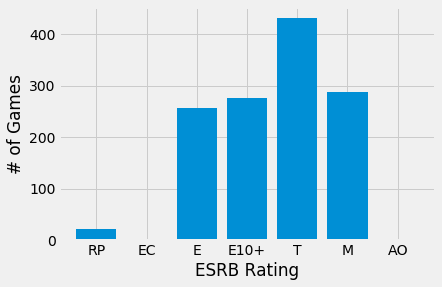

In [241]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
ratings = ['RP', 'EC', 'E', 'E10+', 'T', 'M', 'AO']
plt.bar(ratings, [21, 0, 257, 277, 431, 288, 1])
plt.xlabel('ESRB Rating')
plt.ylabel('# of Games')

Text(0,0.5,'Average Critic and User Rating')

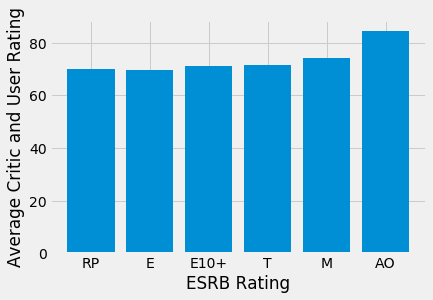

In [242]:
ratings.pop(1)
plt.bar(ratings, [70.068116, 69.484658, 70.982406, 71.390293, 74.143105, 84.348698])
plt.xlabel('ESRB Rating')
plt.ylabel('Average Critic and User Rating')